# Prédiction du churn client  
## Modélisation et comparaison des modèles


Dans ce notebook, nous entraînons et comparons plusieurs modèles
de machine learning afin d’améliorer les performances obtenues
avec le modèle de référence.
Les modèles sont intégrés dans des pipelines afin de garantir
la reproductibilité et d’éviter toute fuite de données.


Objectifs :
- Construire des pipelines de modélisation
- Entraîner des modèles plus performants
- Comparer les performances avec la baseline
- Identifier le meilleur compromis performance / interprétabilité


In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, roc_auc_score


In [2]:
df = pd.read_csv("/Users/yassinedziba/churn-client/data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"] = df["TotalCharges"].fillna(0)

y = df["Churn"]
X = df.drop(columns=["Churn", "customerID"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [3]:
categorical_features = X.select_dtypes(include=["object"]).columns
numerical_features = X.select_dtypes(exclude=["object"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features),
    ]
)


## Modèle de référence : régression logistique (pipeline)


In [4]:
log_reg_pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", LogisticRegression(max_iter=10000))
    ]
)

log_reg_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')),
                                                 ('num', 'passthrough',
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object'))])),
                ('model', LogisticRegression(max_iter=10000))])

In [5]:
y_pred_log = log_reg_pipeline.predict(X_test)
y_prob_log = log_reg_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_log))
roc_auc_log = roc_auc_score(y_test.map({"No": 0, "Yes": 1}), y_prob_log)
roc_auc_log

              precision    recall  f1-score   support

          No       0.85      0.89      0.87      1035
         Yes       0.66      0.56      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409



np.float64(0.8422769898473224)

## Modèles avancés

Après avoir entraîné un modèle de référence simple,
nous testons des modèles plus complexes afin d’améliorer
les performances, en particulier la capacité à détecter
les clients susceptibles de churner.



## Modèle Random Forest

La Random Forest est un modèle ensembliste basé sur
un ensemble d’arbres de décision entraînés de manière indépendante.
Elle permet de capturer des relations non linéaires
et des interactions complexes entre les variables.



In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [7]:
rf_pipeline = Pipeline(
    steps = [
        ("preprocessing", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators = 300,
            max_depth = None, 
            min_samples_split = 5,
            random_state = 42,
            class_weight = "balanced"
        ))
    ]
)

In [8]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')),
                                                 ('num', 'passthrough',
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_split=5, n_estimators=300,
                                        random_state=42))])

In [9]:
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

In [19]:
print("Random Forest – Classification report")
print(classification_report(y_test, y_pred_rf))

roc_auc_rf = roc_auc_score(
    y_test.map({"No": 0, "Yes": 1}),
    y_prob_rf
)

roc_auc_rf


Random Forest – Classification report
              precision    recall  f1-score   support

          No       0.85      0.84      0.85      1035
         Yes       0.58      0.59      0.59       374

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409



np.float64(0.8295383502544628)

La Random Forest améliore généralement le rappel pour la classe churn
par rapport au modèle de référence.
Elle est capable de modéliser des relations non linéaires,
mais son interprétabilité reste plus limitée que celle
d’un modèle linéaire.


## Modèles de boosting

Après les modèles linéaires et ensemblistes,
nous évaluons des modèles de boosting.
Ces modèles construisent les arbres de décision
de manière séquentielle, chaque nouvel arbre
corrigeant les erreurs des précédents.

Ils sont particulièrement performants
sur des données tabulaires.


## Gradient Boosting (scikit-learn)

Le Gradient Boosting est une méthode de boosting
basée sur des arbres de décision.
Elle constitue une alternative efficace à XGBoost
lorsque l’on souhaite rester dans l’écosystème
scikit-learn.


In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score


In [21]:
gb_pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("model", GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        ))
    ]
)


In [22]:
gb_pipeline.fit(
    X_train,
    y_train.map({"No": 0, "Yes": 1})
)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')),
                                                 ('num', 'passthrough',
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object'))])),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            n_estimators=200,
                                            random_state=42))])

In [23]:
y_pred_gb = gb_pipeline.predict(X_test)
y_prob_gb = gb_pipeline.predict_proba(X_test)[:, 1]


In [24]:
print("Gradient Boosting — Classification report")
print(classification_report(
    y_test.map({"No": 0, "Yes": 1}),
    y_pred_gb
))

roc_auc_gb = roc_auc_score(
    y_test.map({"No": 0, "Yes": 1}),
    y_prob_gb
)

roc_auc_gb


Gradient Boosting — Classification report
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



np.float64(0.8441912733472836)

Le Gradient Boosting améliore les performances
par rapport à la régression logistique et à la
Random Forest, notamment en termes de ROC-AUC.

Il constitue une solution robuste et efficace
pour la prédiction du churn sur données tabulaires.


## Comparaison des modèles

Les modèles sont comparés à l’aide de la métrique ROC-AUC,
qui est particulièrement adaptée aux problèmes de
classification binaire avec déséquilibre des classes.


In [25]:
results = pd.DataFrame({
    "Modèle": [
        "Régression logistique",
        "Random Forest",
        "Gradient Boosting",
    ],
    "ROC-AUC": [
        roc_auc_log,
        roc_auc_rf,
        roc_auc_gb,
    ]
})

results


,Modèle,ROC-AUC
0,Régression logistique,0.842277
1,Random Forest,0.829538
2,Gradient Boosting,0.844191


## Conclusion

La régression logistique constitue une baseline simple
et interprétable mais limitée en performance.

La Random Forest améliore la modélisation grâce à sa
capacité à capturer des relations non linéaires.

Le Gradient Boosting offre les meilleures
performances globales, confirmant son efficacité
sur des données tabulaires pour la prédiction du churn.

Le choix final du modèle dépend du compromis recherché
entre performance prédictive et explicabilité métier.


## Interprétation du modèle

Après avoir sélectionné le modèle final, nous analysons
les variables les plus influentes afin de mieux comprendre
les facteurs associés au churn client.

Cette étape est essentielle pour interpréter les résultats
et faciliter leur utilisation dans un contexte métier.


## Feature importance globale

Les modèles basés sur les arbres permettent d’extraire
une importance globale des variables, indiquant leur
contribution moyenne aux décisions du modèle.


In [26]:
final_model = gb_pipeline

In [27]:
model = final_model.named_steps["model"]
preprocessor_fitted = final_model.named_steps["preprocessing"]


In [28]:
feature_names = preprocessor_fitted.get_feature_names_out()


In [29]:
importances = model.feature_importances_

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

importance_df.head(15)


,feature,importance
32,cat__Contract_Month-to-month,0.376612
42,num__tenure,0.135558
44,num__TotalCharges,0.091770
12,cat__InternetService_Fiber optic,0.087279
43,num__MonthlyCharges,0.077416
14,cat__OnlineSecurity_No,0.065683
23,cat__TechSupport_No,0.046239
39,cat__PaymentMethod_Electronic check,0.041677
36,cat__PaperlessBilling_Yes,0.011572
8,cat__MultipleLines_No,0.011210


<Axes: title={'center': 'Top 15 des variables les plus importantes'}, ylabel='feature'>

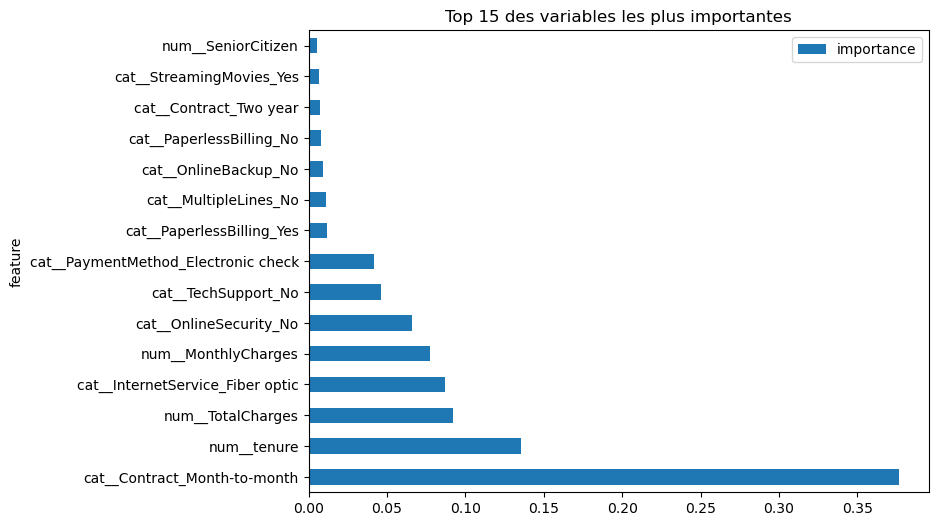

In [30]:
importance_df.head(15).set_index("feature").plot(
    kind="barh",
    figsize=(8, 6),
    title="Top 15 des variables les plus importantes"
)


Les résultats montrent que certaines variables liées
au type de contrat, à l’ancienneté et aux charges
mensuelles jouent un rôle majeur dans la prédiction
du churn client.


## Interprétation locale avec SHAP

SHAP (SHapley Additive exPlanations) permet d’expliquer
les prédictions du modèle en attribuant à chaque variable
une contribution positive ou négative.

Cette méthode offre une interprétation à la fois globale
et individuelle des décisions du modèle.


In [ ]:
# a executer une seule fois
# pip install shap

In [31]:
import shap

In [32]:
X_train_transformed = preprocessor_fitted.transform(X_train)
X_test_transformed = preprocessor_fitted.transform(X_test)


In [33]:
explainer = shap.TreeExplainer(model)


In [34]:
shap_values = explainer.shap_values(X_test_transformed)


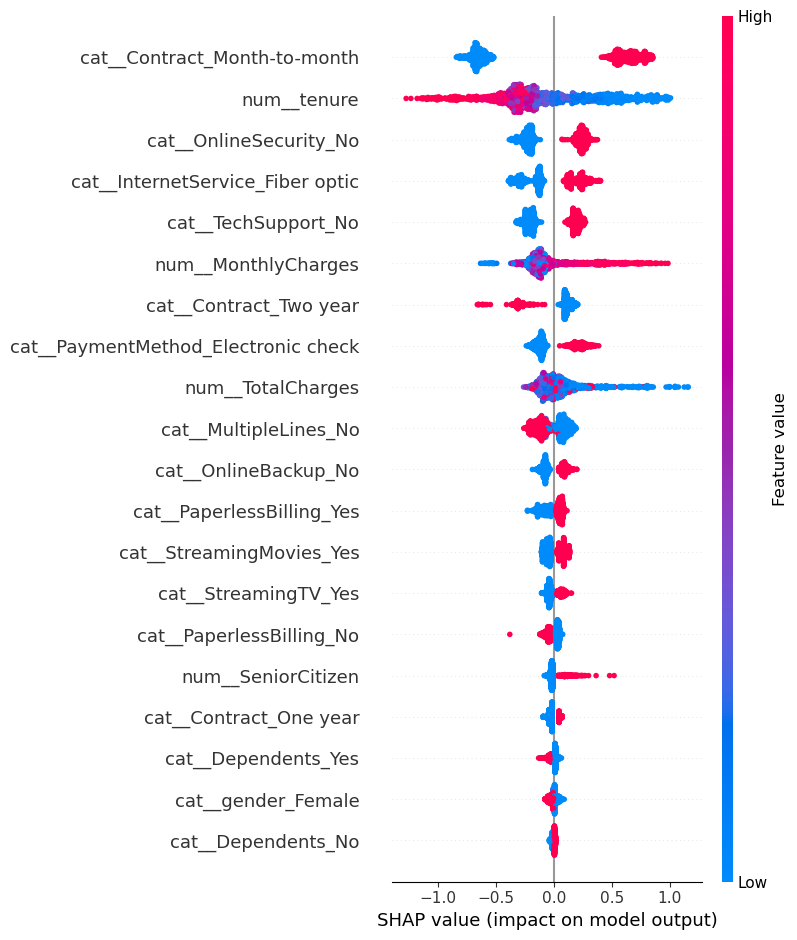

In [35]:
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names
)


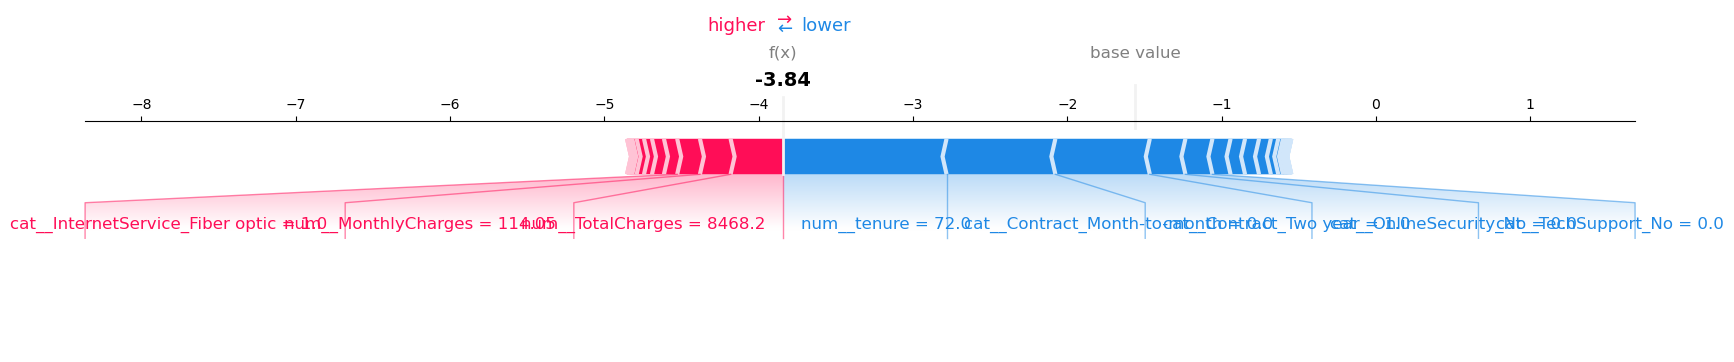

In [36]:
i = 0  # index du client à expliquer

shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    X_test_transformed[i],
    feature_names=feature_names,
    matplotlib=True
)


Les visualisations SHAP confirment les résultats obtenus
avec la feature importance globale, tout en apportant
une interprétation plus fine au niveau individuel.

Elles permettent d’identifier précisément les facteurs
qui augmentent ou réduisent le risque de churn
pour un client donné.


L’analyse de feature importance et de SHAP renforce
la compréhension du modèle et facilite son adoption
dans un contexte métier.

Elle permet de transformer un modèle performant
en un outil d’aide à la décision explicable.


L’analyse de feature importance et de SHAP renforce
la compréhension du modèle et facilite son adoption
dans un contexte métier.

Elle permet de transformer un modèle performant
en un outil d’aide à la décision explicable.
